# Estimating Turnover in Retail Trade

### Capstone Project by Christian Furger 

The Retail Trade Turnover Statistics (DHU) is a monthly economic statistic by the Federal Statistical Office (FSO) describing the evolution of turnover in retail trade at the national level. The survey population comprises all enterprises active in retail trade which are domiciled in Switzerland. Large and medium enterprises are surveyed exhaustively, small enterprises are surveyed randomly. The sample consists of around 4000 enterprises. Large enterprises are surveyed each month, the others four times per year, when monthly data are collected. To be able to publish representative results every month, data for three months are collected with one questionnaire for small and medium enterprises, but shifted by zero, one or two month for the three sub-samples. More information can be found on the FSO website: www.dhu.bfs.admin.ch

#### Goal of this project
At the time of the calculation of the results, not all enterprises have responded to the survey. Furthermore, the data users wish first estimations even earlier. Therefore, the goal of this project is to find methods to estimate the turnover of a given enterprise for a given month by using the information available from other respondents and the past.

## Exploratory Data Analysis (EDA)

In [1]:
# Import statements
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Admin_Data

In [2]:
# Importing Admin_Data
admin_data = pd.read_csv('admin_data_prep.csv',  dtype = {'Stratum_Noga' : object, 'Stratum_Size' : object, 'Noga_Enterprise' : object, 'Hist_Limit' : object})
admin_data.shape

(6299, 16)

In [3]:
admin_data.head()

,OID,KT,ZIP,Lang,Stratum_Noga,Empl_Enterprise,Stratum_Size,FTE_Enterprise,Profiling,Sample_ID,Noga_Enterprise,Hist_Limit,Empl_RT,Sample_1,Sample_2,Resp
0,1001536,TI,6596,3,475,1,1,0.98,0,Q1,4752,201801,1.0,0,1,0
1,1002489,LU,6004,1,477,6,1,5.25,0,Q3,4778,201401,6.0,1,0,0
2,1002813,TI,6830,3,476,3,1,2.30,0,Q2,4761,201401,3.0,1,0,0
3,1004201,GE,1227,2,476,264,1,14.00,0,M,4649,201401,14.0,1,0,0
4,1005483,ZH,8048,1,476,3,1,2.14,0,Q2,4765,201401,3.0,1,0,0


For the EDA only responding enterprises (Resp=1) are analyzed.

In [4]:
admin_num=['Empl_Enterprise','FTE_Enterprise','Empl_RT']

admin_resp=admin_data[admin_data['Resp']==1].copy()
admin_resp[admin_num].describe().round(2)

,Empl_Enterprise,FTE_Enterprise,Empl_RT
count,4395.00,4395.00,4391.00
mean,63.75,40.31,52.67
std,716.86,493.92,630.62
min,1.00,0.11,1.00
25%,4.00,2.96,4.00
50%,9.00,6.48,9.00
75%,22.00,15.30,20.00
max,35032.00,22134.79,28022.00


The employment variables are skewed. Therefore, the log is taken for further analysis.

C:\Users\Christian\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Christian\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\Christian\anaconda3\envs\exts-ml\lib\site-packages\statsmodels\nonparametric\kde.py:547: RuntimeWarning: invalid value encountered in greater
  x = x[np.logical_and(x > clip[0], x < clip[1])]
C:\Users\Christian\anaconda3\envs\exts-ml\lib\site-packages\statsmodels\nonparametric\kde.py:547: RuntimeWarning: invalid value encountered in less
  x = x[np.logical_and(x > clip[0], x < clip[1])]


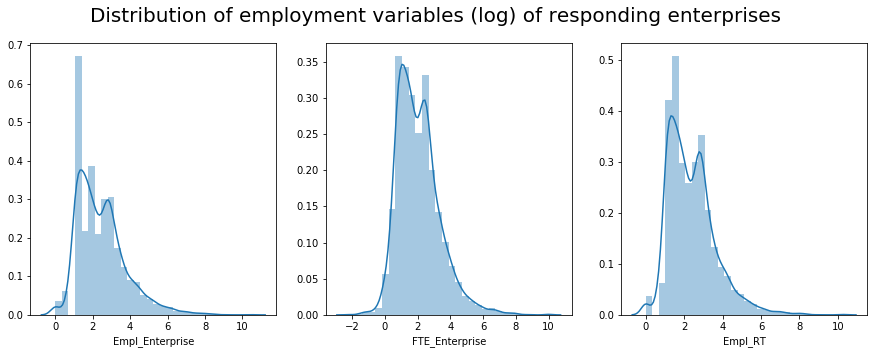

In [5]:
fig, axs = plt.subplots(1,len(admin_num),figsize=(5*len(admin_num),5))

sns.distplot(np.log(admin_resp['Empl_Enterprise']), kde=True, bins=30, ax=axs[0])
sns.distplot(np.log(admin_resp['FTE_Enterprise']), kde=True, bins=30, ax=axs[1])
sns.distplot(np.log(admin_resp['Empl_RT']), kde=True, bins=30, ax=axs[2])
plt.suptitle('Distribution of employment variables (log) of responding enterprises', fontsize=20);

#### Monthly Responses 

In [6]:
# Importing Responses
resp_data = pd.read_csv('resp_data_prep.csv',  dtype = {'Stratum_Noga' : object, 'Stratum_Size' : object, 'Noga_Enterprise' : object, 'Hist_Limit' : object})
resp_data.shape

(143933, 37)

In [7]:
resp_data.head()

,OID,KT,ZIP,Lang,Stratum_Noga,Empl_Enterprise,Stratum_Size,FTE_Enterprise,Profiling,Sample_ID,...,SentFor,TOV,nb_modif,Date,Year,Month,Lockdown,TOV_lag1,TOV_lag2,TOV_lag12
0,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,552,1,2015-01,2015,1,0.0,681.0,599.0,519.0
1,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,554,1,2015-02,2015,2,0.0,552.0,681.0,523.0
2,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,629,1,2015-03,2015,3,0.0,554.0,552.0,600.0
3,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,546,1,2015-04,2015,4,0.0,629.0,554.0,560.0
4,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,569,1,2015-05,2015,5,0.0,546.0,629.0,582.0


In [8]:
resp_data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
OID,143933.0,5513182.58,2568087.05,1005620.00,3352189.00,5497043.0,7728034.00,9999019.00
ZIP,143933.0,5305.72,2750.66,1003.00,3011.00,5630.0,8008.00,9999.00
Lang,143933.0,1.36,0.59,1.00,1.00,1.0,2.00,3.00
Empl_Enterprise,143933.0,108.96,1051.76,1.00,5.00,15.0,35.00,35032.00
FTE_Enterprise,143933.0,69.33,725.24,0.11,3.74,10.1,24.06,22134.79
Profiling,143933.0,0.05,0.22,0.00,0.00,0.0,0.00,1.00
Empl_RT,143829.0,90.35,925.91,1.00,5.00,15.0,30.00,28022.00
Sample_1,143933.0,0.83,0.38,0.00,1.00,1.0,1.00,1.00
Sample_2,143933.0,0.44,0.50,0.00,0.00,0.0,1.00,1.00
Resp,143933.0,1.00,0.00,1.00,1.00,1.0,1.00,1.00


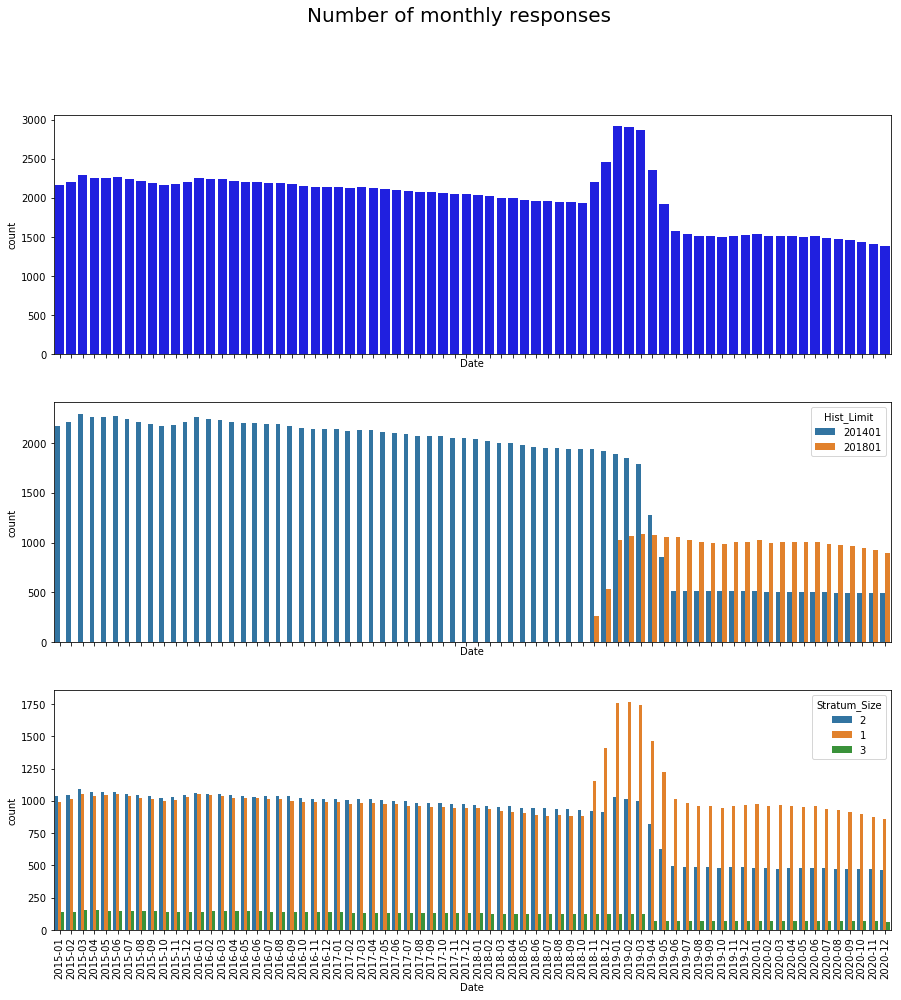

In [9]:
# Number of monthly responses
fig, axs = plt.subplots(3,1,figsize=(15,15), sharex=True)
plt.suptitle('Number of monthly responses', fontsize=20);
plt.xticks(rotation=90);

sns.catplot(x='Date', kind='count', color='blue', data=resp_data, ax=axs[0])
plt.close()
sns.catplot(x='Date', kind='count', hue='Stratum_Size', data=resp_data, ax=axs[2])
plt.close()
sns.catplot(x='Date', kind='count', hue='Hist_Limit', data=resp_data, ax=axs[1])
plt.close()

The spike in the number of responses around the beginning of 2019 comes from the introduction of the new sample. The old sample was surveyed until 2019-05 (for the last sub-sample), the new sample was introduced in 2019-01 (survey periods of first sub-sample: 2018-11, 2018-12, 2019-01). The size of the new sample is smaller than that of the old one.

In [10]:
# log-transformation of numerical variables
resp_data['Empl_Enterprise_log']=np.log(resp_data['Empl_Enterprise'])
resp_data['FTE_Enterprise_log']=np.log(resp_data['FTE_Enterprise'])
resp_data['Empl_RT_log']=np.log(resp_data['Empl_RT'])
resp_data['VAT_log']=np.log1p(resp_data['VAT'])
resp_data['TOV_log']=np.log1p(resp_data['TOV'])
resp_data['TOV_lag1_log']=np.log1p(resp_data['TOV_lag1'])
resp_data['TOV_lag2_log']=np.log1p(resp_data['TOV_lag2'])
resp_data['TOV_lag12_log']=np.log1p(resp_data['TOV_lag12'])

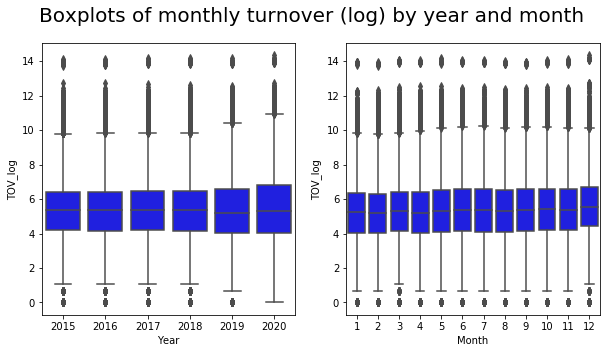

In [11]:
# Boxplots of monthly responses by different categories
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Boxplots of monthly turnover (log) by year and month',fontsize=20)
sns.catplot(x='Year', y='TOV_log', kind='box', color='blue', data=resp_data, ax=axes[0])
plt.close()
sns.catplot(x='Month', y='TOV_log', kind='box', color='blue', data=resp_data, ax=axes[1])
plt.close()

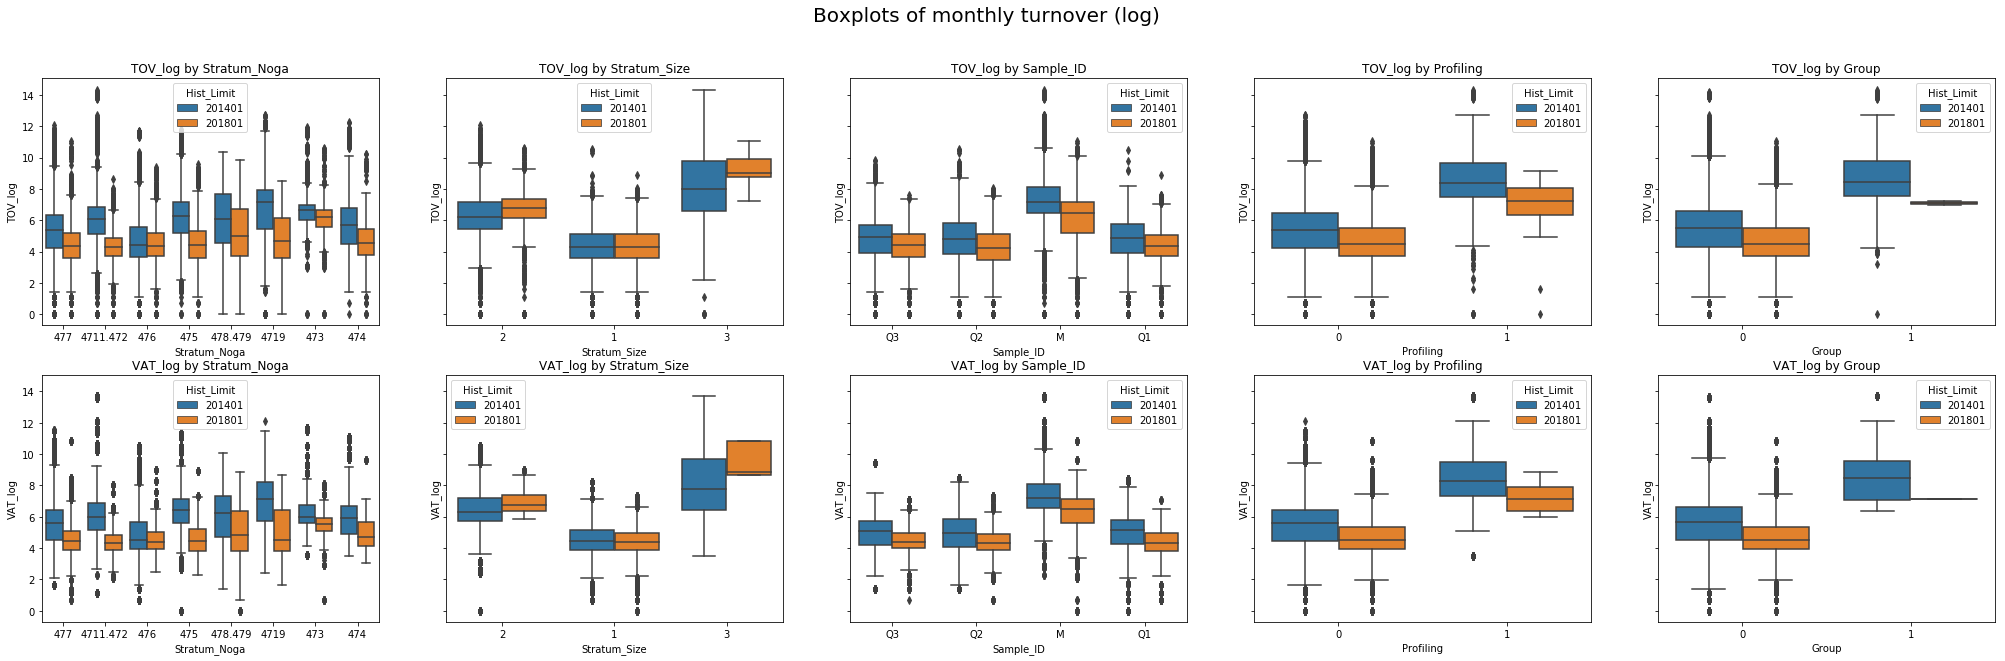

In [12]:
# Boxplots of monthly responses by different categories
resp_cats=['Stratum_Noga','Stratum_Size','Sample_ID','Profiling','Group']
resp_vars=['TOV_log','VAT_log']

fig, axes = plt.subplots(len(resp_vars), len(resp_cats), figsize=(len(resp_cats)*7, len(resp_vars)*5), sharey=True)
fig.suptitle('Boxplots of monthly turnover (log)',fontsize=20)

for c in range(0,len(resp_vars)):
    for r in range(0,len(resp_cats)):
        axes[c,r].set_title(resp_vars[c]+' by '+resp_cats[r])
        sns.catplot(ax=axes[c,r], x=resp_cats[r], y=resp_vars[c], kind='box', hue='Hist_Limit', data=resp_data);
        plt.close()        

There seems to be a clear distinction between enterprises taking part in profiling and those which are not, as well as between those forming Groups and the others. Turnover of enterprises belonging to Stratum_Size 3 or Sample_ID 'M' is unsurprisingly higher than that of the others, as these are the big enterprises.

There are significant outliers. These have to be treated before estimating any model.

In [13]:
# Calculating number of responses per year per enterprise
nb_resp=resp_data.groupby(['Year','OID']).agg({'OID': ['count']}).reset_index()
nb_resp.columns=('Year','OID','Nb resp per Year')
nb_resp.sort_values(by=['OID','Year'])

,Year,OID,Nb resp per Year
0,2015,1005620,12
2586,2016,1005620,12
5046,2017,1005620,12
7351,2018,1005620,12
10057,2019,1005620,3
...,...,...,...
7350,2017,9997218,9
10056,2018,9997218,12
13353,2019,9997218,4
13354,2019,9999019,12


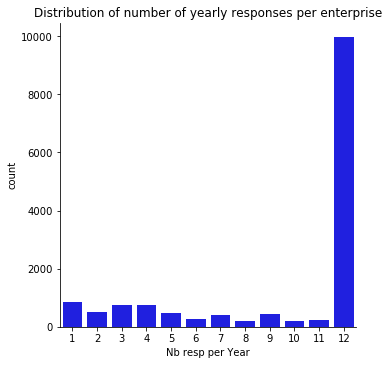

In [14]:
sns.catplot(x='Nb resp per Year', kind='count', data=nb_resp, color='blue')
plt.title('Distribution of number of yearly responses per enterprise');

Most of the enterprises respond regularly, e.g. they respond 12 times a year.

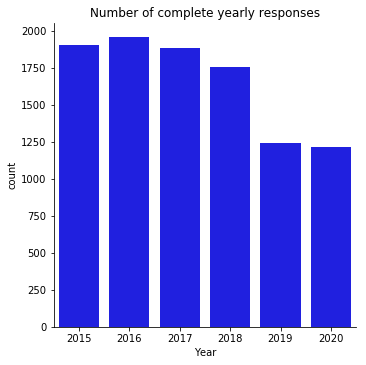

In [15]:
# Calculating complete responses per year
yr_compl=nb_resp[nb_resp['Nb resp per Year']==12]
sns.catplot(x='Year', kind='count', data=yr_compl, color='blue')
plt.title('Number of complete yearly responses');

The number of complete responses drops significantly in 2019. This is due to the smaller sample size.

In [16]:
# Selecting only complete yearly responses
resp_compl=pd.merge(yr_compl, resp_data, on=['OID','Year'])
resp_compl.shape

(119544, 46)

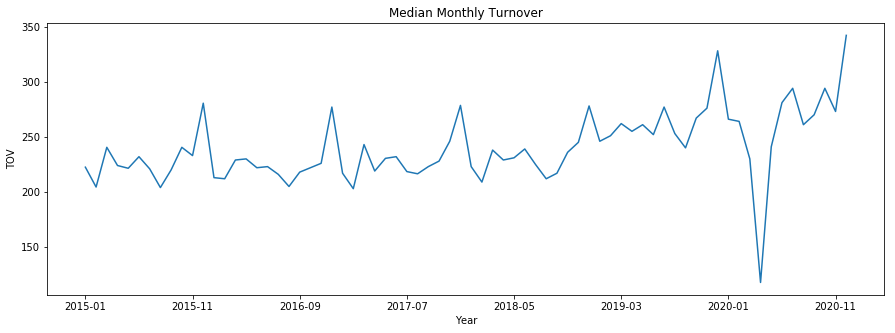

In [17]:
# Median monthly turnover
by_date=resp_compl['TOV'].groupby(resp_compl['Date']).median()

by_date.plot(figsize=(15, 5))
plt.title('Median Monthly Turnover')
plt.xlabel('Year')
plt.ylabel('TOV')
plt.show()

There is a clear seasonal pattern visible for median monthly turnover with december being the month with the highest turnover. The effect of the first corona lockdown in march/april 2020 is also clearly visible.

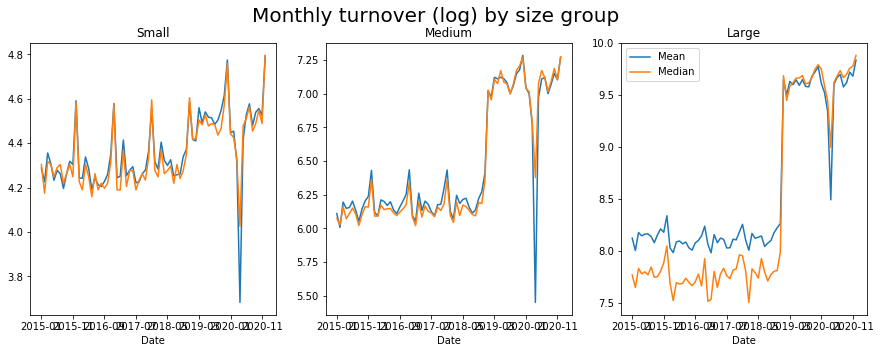

In [18]:
# Monthly turnover by size group
size=['Small','Medium','Large']

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Monthly turnover (log) by size group',fontsize=20)

for s in ('1','2','3'):
    t=int(s)-1    
    locals()['mean_{}'.format(s)]=resp_compl[resp_compl['Stratum_Size']==s]['TOV_log'].groupby(resp_compl['Date']).mean()
    locals()['median_{}'.format(s)]=resp_compl[resp_compl['Stratum_Size']==s]['TOV_log'].groupby(resp_compl['Date']).median()      
    locals()['mean_{}'.format(s)].plot(ax=ax[t], title=size[t], label='Mean')
    locals()['median_{}'.format(s)].plot(ax=ax[t], title=size[t], label='Median')

plt.legend();

For medium and large enterprises there seems to be a level shift between the two samples. This is probably due to the smaller sample size and/or the increased stratification limits.

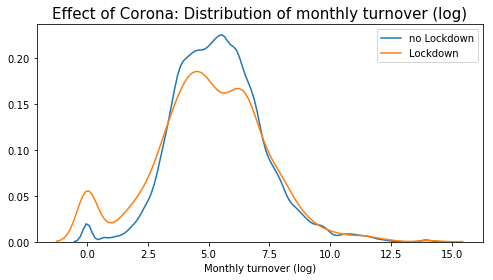

In [19]:
# Distribution of monthly turnover - effect of the lockdown during the coronavirus pandemic
plt.subplots(figsize=(8,4)) 

c0=resp_data.loc[resp_data.Lockdown==0]
c1=resp_data.loc[resp_data.Lockdown==1]

sns.distplot(c0['TOV_log'], kde=True, hist=False, label='no Lockdown')
sns.distplot(c1['TOV_log'], kde=True, hist=False, label='Lockdown')
plt.title('Effect of Corona: Distribution of monthly turnover (log)', fontsize=15)
plt.xlabel('Monthly turnover (log)')
plt.legend()
plt.show()

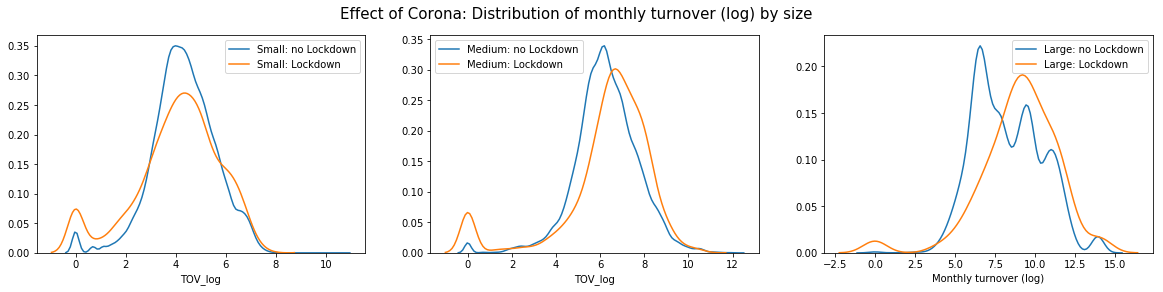

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

size=['Small','Medium','Large']

c0=resp_data.loc[resp_data.Lockdown==0]
c1=resp_data.loc[resp_data.Lockdown==1]

for s in ('1','2','3'):
    t=int(s)-1
    plt.suptitle('Effect of Corona: Distribution of monthly turnover (log) by size', fontsize=15)
    s0=c0.loc[c0['Stratum_Size']==s]
    s1=c1.loc[c1['Stratum_Size']==s]
    #plt.title(size[t])
    sns.distplot(s0['TOV_log'], kde=True, hist=False, label=size[t]+': no Lockdown', ax=axes[t])
    sns.distplot(s1['TOV_log'], kde=True, hist=False, label=size[t]+': Lockdown', ax=axes[t])    
    plt.xlabel('Monthly turnover (log)')
    #plt.legend(loc='upper right')

plt.show()

The coronavirus pandemic had different effects depending on the size of the companies. For all sizes, the number of companies/months with zero turnover has increased during Lockdown. Small companies had lower turnover during lockdown, whereas medium and big enterprises were able to increase their turnover.

In [21]:
# Mean turnover by canton
resp_data.groupby(['KT'])['TOV'].mean().to_frame('Mean Turnover')

,Mean Turnover
KT,
AG,2159.704230
AI,353.782051
AR,167.173701
BE,753.383128
BL,883.002646
BS,592.935901
CH,87739.451916
FR,1230.972766
GE,1021.107852


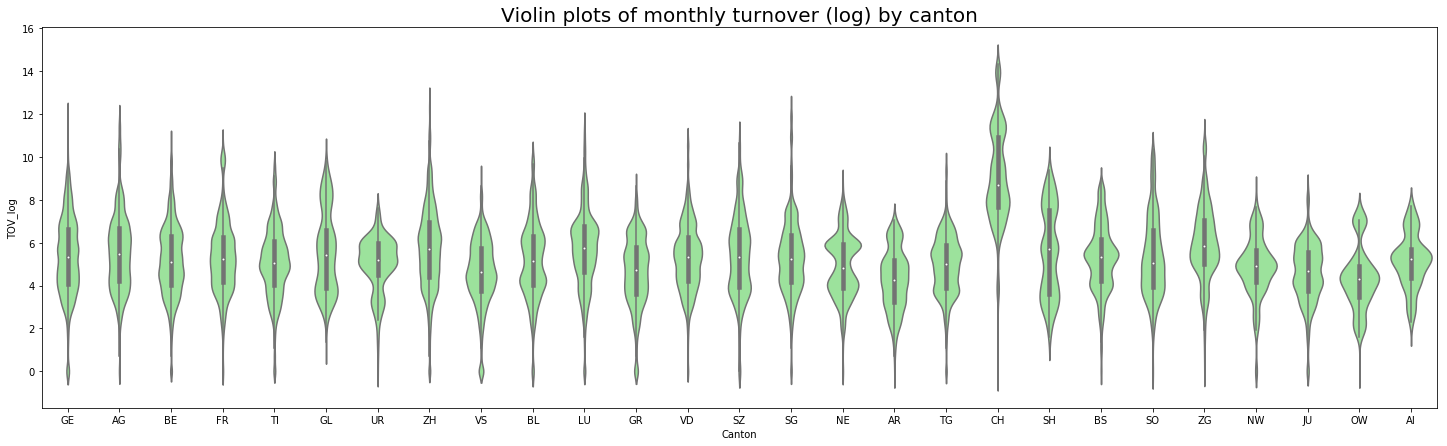

In [22]:
# Distribution of monthly turnover by canton
plt.subplots(figsize=(25,7)) 
sns.violinplot(x=resp_data.KT, y=resp_data['TOV_log'], color='lightgreen')
plt.title('Violin plots of monthly turnover (log) by canton', fontsize=20)
plt.xlabel('Canton')
plt.show()

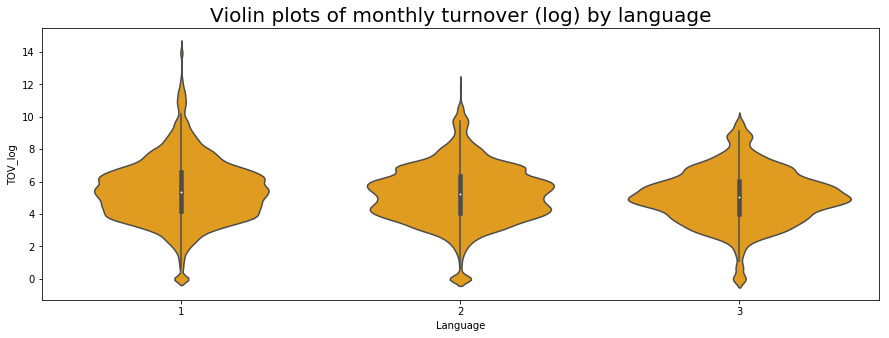

In [23]:
# Distribution of monthly turnover by language
plt.subplots(figsize=(15,5)) 
sns.violinplot(x=resp_data.Lang, y=resp_data['TOV_log'], color='orange')
plt.title('Violin plots of monthly turnover (log) by language', fontsize=20)
plt.xlabel('Language')
plt.show()

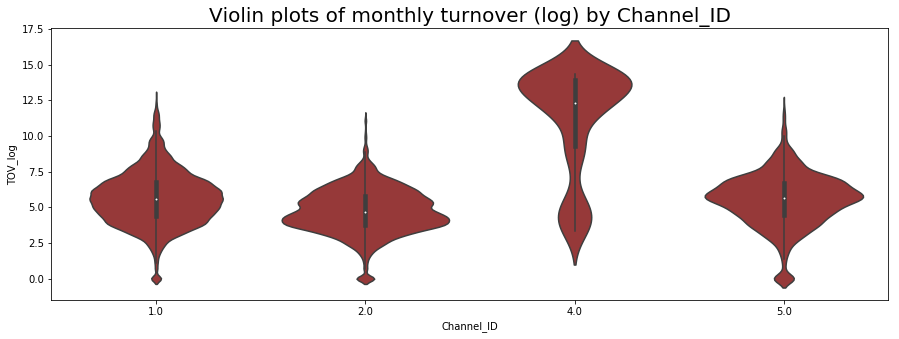

In [24]:
# Distribution of monthly turnover by Channel_ID
plt.subplots(figsize=(15,5)) 
sns.violinplot(x=resp_data.Channel_ID, y=resp_data['TOV_log'], color='brown')
plt.title('Violin plots of monthly turnover (log) by Channel_ID', fontsize=20)
plt.xlabel('Channel_ID')
plt.show()

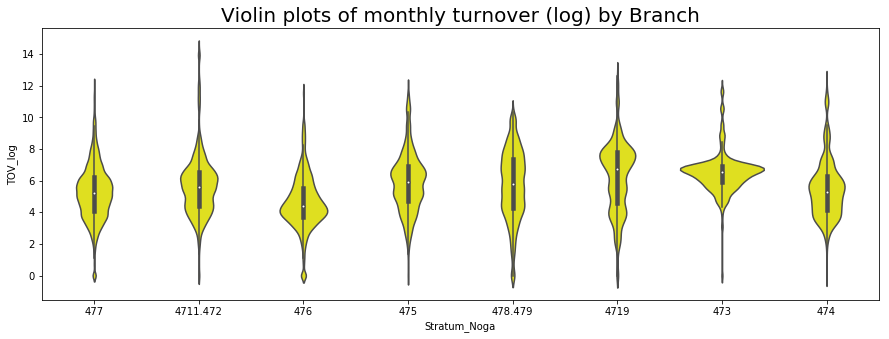

In [25]:
# Distribution of monthly turnover by Branch
plt.subplots(figsize=(15,5)) 
sns.violinplot(x=resp_data.Stratum_Noga, y=resp_data['TOV_log'], color='yellow')
plt.title('Violin plots of monthly turnover (log) by Branch', fontsize=20)
plt.xlabel('Stratum_Noga')
plt.show()

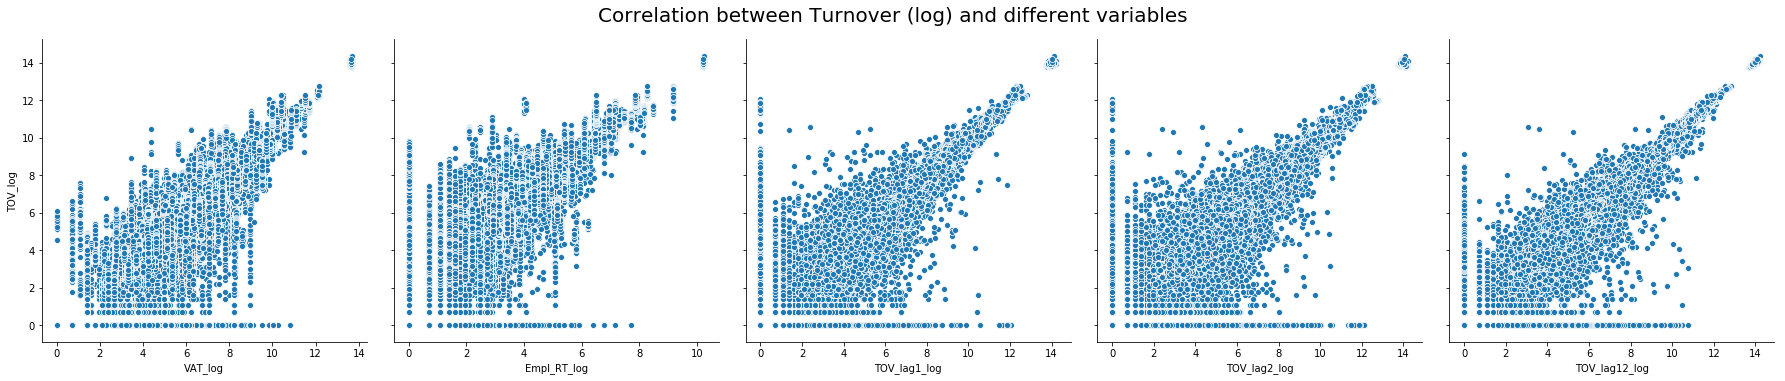

In [26]:
# Correlation with the target variable 'TOV'
variables=['VAT_log', 'Empl_RT_log', 'TOV_lag1_log', 'TOV_lag2_log', 'TOV_lag12_log']
sns.pairplot(y_vars='TOV_log', x_vars=variables, data=resp_data, height=5)
plt.suptitle('Correlation between Turnover (log) and different variables', fontsize=20, y=1.05);

There is a clear correlation between the target variable 'TOV' and employment, VAT and the lagged turnover.

### How does the EDA inform the project plan?

Different features seem to have an influence on the target variable:
* There seems to be a clear distinction between enterprises taking part in profiling and those which are not, as well as between those forming Groups and the others.
* Turnover of enterprises belonging to Stratum_Size 3 or Sample_ID 'M' is unsurprisingly higher than that of the others, as these are the big enterprises.
* Monthly turnover seems to follow a seasonal pattern.
* There is a strong correlation between the target variable and its lags.
* There is also a correlation between the target variable and employent or VAT.
* Mean turnover is different by canton.
* The target variable seems to vary by channel_ID, whereas the language of the enterprise doesn't seem to have an influence.

It should therefore be possible to find models for imputing turnover.